# TabTransformer

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch    
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import time
import random
#ordinal encoder
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
#import lda and pca
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import itertools
import copy


# seed and device definition

In [10]:
SEED = 42
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower
fix_random(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Using device:', device)

Using device: cuda


# tabtransformer class definition

In [11]:
class TabTransformer(torch.nn.Module):
    def __init__(self, num_features, num_classes, dim_embedding=8, num_heads=2, num_layers=2):
        super(TabTransformer, self).__init__()
        self.embedding = torch.nn.Linear(num_features, dim_embedding)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = torch.nn.Linear(dim_embedding, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Adding a sequence length dimension
        x = self.transformer(x)
        x = torch.mean(x, dim=1)  # Pooling
        x = self.classifier(x)
        return x

# train and test function

In [12]:
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, scheduler, patience):
    n_iter = 0

    best_model = None
    best_val_loss = float('inf')
    epochs_since_last_improvement = 0

    start = time.time()

    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()

        start_epoch = time.time()

        loss_train = 0
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets.long())
            loss.backward()
            optimizer.step()
            n_iter += 1
            loss_train += loss.item()

        scheduler.step()
        loss_train /= len(data_loader)

        # Compute Val Loss
        val_loss,_,_ = test_model(model, criterion, val_loader)

        loss_history.append(loss_train)
        val_loss_history.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_since_last_improvement = 0
        elif epochs_since_last_improvement >= patience:
            break
        else:
            epochs_since_last_improvement += 1

        print('Epoch [{}/{}] - {:.2f} seconds - train_loss: {:.6f} - val_loss: {:.6f} - patience: {}'.format(epoch+1,
              epochs, time.time() - start_epoch, loss_train, val_loss, epochs_since_last_improvement), end='\r')

    print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(time.time() - start, best_val_loss))

    return best_model, loss_history, val_loss_history


def test_model(model, criterion, loader):
    model.eval()
    y_pred = torch.tensor([],requires_grad=True).to(device)
    y_true = torch.tensor([],requires_grad=True).to(device)

    total_loss = 0.0
    
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        preds = model(data)
        loss = criterion(preds, targets.long())
        total_loss += loss.item()
        y_pred = torch.cat((y_pred, preds.squeeze()))
        y_true = torch.cat((y_true, targets.detach()))

    avg_loss = total_loss / len(loader)
    return avg_loss, y_pred.squeeze(), y_true.squeeze()

# DEFINE TRAIN, VALIDATION AND TEST SET

In [13]:


#read the dataset
df = pd.read_csv('train_dataset.csv')

#DATA CLEANING

#filter numerical columns
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

#filter categorical columns
cat_columns = df.select_dtypes(include=[object]).columns.tolist()

# replace '-' values in n columns with the mean of the column(both int and float columns)
for column in num_columns:
    df[column] = df[column].replace('-', df[column].mean())

# replace '-' values in categorical columns with the mode of the column
for column in cat_columns:
    df[column] = df[column].replace('-', df[column].mode().iloc[0])

# Convert all categorical columns to strings
df[cat_columns] = df[cat_columns].astype(str)

encoder = OrdinalEncoder()
df[cat_columns] = encoder.fit_transform(df[cat_columns])

X = df.drop(columns=["type"]).to_numpy()
y = df["type"].to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Encoding target
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


#PREPROCESSING

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Apply LDA
# lda = LinearDiscriminantAnalysis()
# X_train = lda.fit_transform(X_train, y_train)
# X_test = lda.transform(X_test)

#apply PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)



print(f'X_train shape after lda: {X_train.shape}')

num_feature = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Split train data into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

#tensors creation

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=Y_val.shape[0], shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=y_test.shape[0], shuffle=False)

C:\Users\rinal\AppData\Local\Temp\ipykernel_31396\2255167938.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_dataset.csv')


X_train shape after lda: (493601, 23)


In [14]:
#import class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(4.090503024778321), 1: np.float64(0.33785378407791977), 2: np.float64(1.1352107817207515), 3: np.float64(4.499553327256153), 4: np.float64(98.13141153081511), 5: np.float64(2.977086851628468), 6: np.float64(1.198846331333641), 7: np.float64(63.44485861182519), 8: np.float64(0.2880087989543948), 9: np.float64(0.9761519598148953)}


# hp configuration

In [15]:
nums_epochs = [20,30]
batch_sizes = [256,512]
patience = [10,20]
dim_embedding = [16]
num_heads = [8,16]
num_layers = [16,32]
learning_rate = [0.001]
hyperparameters = list(itertools.product(nums_epochs, batch_sizes, patience, dim_embedding, num_heads, num_layers, learning_rate))
n_comb = len(hyperparameters)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 64


# best model

In [16]:
# Initialize the model, loss, and optimizer
best_loss = float('inf')
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device))
current_iter = 0
for epochs, batch_size, patience_, dim_embedding_, num_heads_, num_layers_, lr in hyperparameters:

    print(f'Iteration {current_iter+1}/{n_comb} - Hyperparameters: epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}')
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, drop_last=True)

    model = TabTransformer(num_feature, num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    model, loss_history, val_loss_history = train_model(model, criterion, optimizer, epochs, train_loader, val_loader, device, scheduler, patience_)
    val_loss, y_pred, y_true = test_model(model, criterion, val_loader)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        best_hyperparameters = f"epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}"
    print(f'Hyperparameters: epochs={epochs}, batch_size={batch_size}, patience={patience_}, dim_embedding={dim_embedding_}, num_heads={num_heads_}, num_layers={num_layers_}, lr={lr}')
    print(f'Validation Loss: {val_loss}')
    current_iter += 1

print(f'Best hyperparameters: {best_hyperparameters}')

#save model
torch.save(best_model.state_dict(), 'best_tabtransformer.pth')


Iteration 1/64 - Hyperparameters: epochs=10, batch_size=128, patience=10, dim_embedding=16, num_heads=8, num_layers=8, lr=0.001


RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


 # prediction

Best hyperparameters: epochs=5, batch_size=128, patience=20, dim_embedding=16, num_heads=8, num_layers=2, lr=0.001
Test Loss: 0.017188826575875282
Test Accuracy: 0.9976985599792546


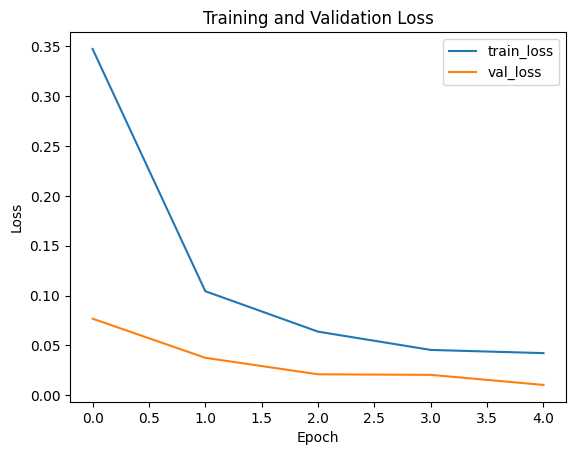

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3094
         1.0       1.00      1.00      1.00     36386
         2.0       1.00      1.00      1.00     10997
         3.0       0.97      1.00      0.98      2609
         4.0       0.96      0.99      0.98       122
         5.0       1.00      1.00      1.00      4099
         6.0       0.99      1.00      0.99     10384
         7.0       0.98      0.99      0.99       188
         8.0       1.00      1.00      1.00     42820
         9.0       1.00      0.99      1.00     12702

    accuracy                           1.00    123401
   macro avg       0.99      1.00      0.99    123401
weighted avg       1.00      1.00      1.00    123401



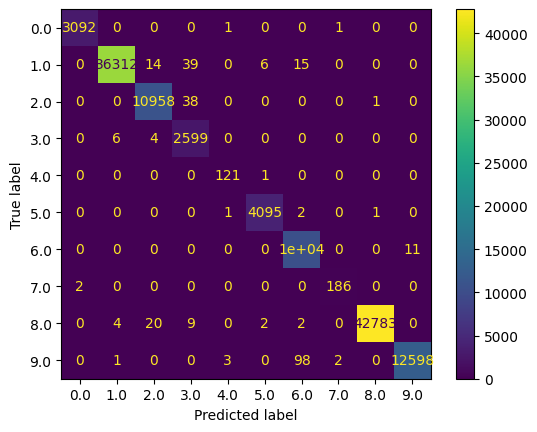

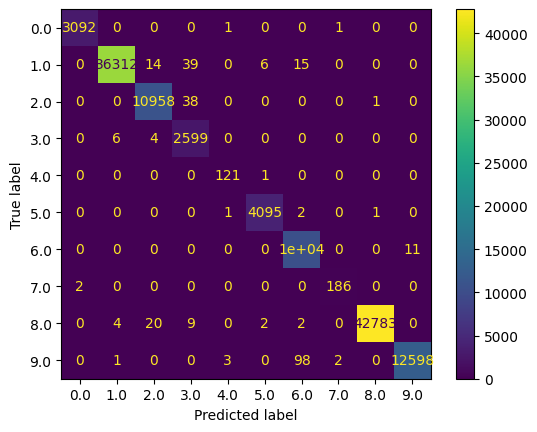

In [16]:
test_loss, y_pred, y_true = test_model(best_model, criterion, test_loader)
y_pred = torch.argmax(y_pred, dim=1)
print(f'Best hyperparameters: {best_hyperparameters}')
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {accuracy_score(y_true.detach().numpy(), y_pred.detach().numpy())}')
plt.plot(loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
#put some labels on x and y axis
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#compute the classficication report
from sklearn.metrics import classification_report
target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

#compute the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()